In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

labels = np.loadtxt('data/comma_ai/train.txt', delimiter='\n')
labels = pd.DataFrame({'speed': labels}).drop(0)
labels = labels.sort_values('speed').reset_index().rename(columns={'index': 'frame'})


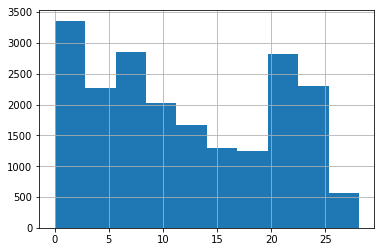

In [7]:
labels['speed'].hist()

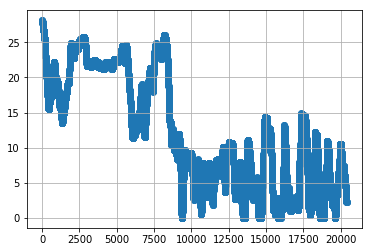

In [8]:
plt.scatter(labels['frame'], labels['speed'])
plt.grid()

In [9]:
def interframe_distance(train, test):
    distance = []
    test = list(np.sort(test['frame'].values))
    train = list(np.sort(train['frame'].values))
    
    prev_sample = train.pop()
    while len(train) > 0:
        current_sample = train.pop()
        while len(test) > 0 and test[-1] > prev_sample:
            test.pop()
        while len(test) > 0 and prev_sample > test[-1] and test[-1] > current_sample:
            test_sample = test.pop()
            distance.append(min(prev_sample - test_sample, test_sample - current_sample))
        prev_sample = current_sample
    
    return np.array(distance)

# Interframe Distance

This is the metric we want to maximize when constructing our train and test groups in order to prevent overfitting on the subtle attribtues in a single frame.  Since the actual changes between two adjacent frames is quite similar.

However we still wish to keep the distribution of speed in the train and test groups in order not to introduce a bias when validating the model

In [87]:
def block_based_split(labels, train_size, test_size, train_block_size, test_block_size, random_state=420):
    labels = labels.sort_values('frame').reset_index(drop=True)
    
    total_block_size = train_block_size + test_block_size
    block_count = len(labels) / total_block_size
    
    samples_per_train_block = int(np.floor(train_size * len(labels) / block_count))
    samples_per_test_block = int(np.floor(test_size * len(labels) / block_count))
    
    train_blocks = []
    test_blocks = []
    for i in range(len(labels) / total_block_size):
        train_block = labels.iloc[i*total_block_size : i*total_block_size + train_block_size]
        test_block = labels.iloc[i*total_block_size + train_block_size : (i + 1)*total_block_size]

        train_blocks.append(train_block.sample(samples_per_train_block, random_state=random_state*i))
        test_blocks.append(test_block.sample(samples_per_test_block, random_state=random_state*i))
        
    return pd.concat(train_blocks), pd.concat(test_blocks)
        

In [88]:
train_1, test_1 = train_test_split(labels, train_size=0.1, test_size=0.05, random_state=420)
train_2, test_2 = train_test_split(labels, train_size=0.2, test_size=0.1, random_state=420)
train_3, test_3 = train_test_split(labels, train_size=0.3, test_size=0.15, random_state=420)
train_4, test_4 = block_based_split(labels, 0.1, 0.05, 60, 30)
train_5, test_5 = block_based_split(labels, 0.2, 0.1, 120, 60)
train_6, test_6 = block_based_split(labels, 0.3, 0.15,200, 100)

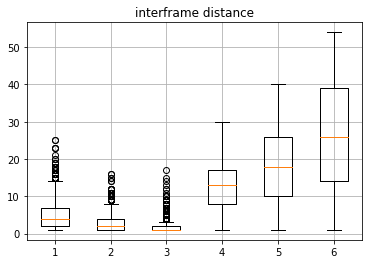

In [89]:
plt.boxplot([
    interframe_distance(train_1, test_1), 
    interframe_distance(train_2, test_2), 
    interframe_distance(train_3, test_3),
    interframe_distance(train_4, test_4),
    interframe_distance(train_5, test_5),
    interframe_distance(train_6, test_6),
])
plt.grid()
plt.title('interframe distance')

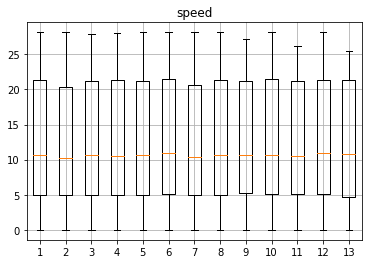

In [90]:
plt.boxplot([
    labels['speed'],
    train_1['speed'], test_1['speed'],
    train_2['speed'], test_2['speed'],
    train_3['speed'], test_3['speed'],
    train_4['speed'], test_4['speed'],
    train_5['speed'], test_5['speed'],
    train_6['speed'], test_6['speed'],
])
plt.grid()
plt.title('speed')